<a href="https://colab.research.google.com/github/AUT-Student/IR-HW1/blob/main/IR_HW1_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><b>In the name of God</b></center>

<b>Course</b>: Information Retrieval
<br>
<b>Description:</b> HomeWork 1 & HomeWork 2
<br>
<b>Developer</b>: Alireza Mazochi (400131075)

# Libraries

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 13.4 MB/s 
     |████████████████████████████████| 182 kB 63.5 MB/s 
     |████████████████████████████████| 7.6 MB 54.1 MB/s 


In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import time
from heapq import nlargest

import torch
from transformers import BertTokenizer, BertModel

import tensorflow as tf

In [2]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import gensim.downloader as api
from gensim.models.wrappers import FastText

# Dataset

In [4]:
!gdown 1uJYlPDV4-V-hHQSIhlq1ruKBL6SR96Te
!unzip /content/IR_HW1_dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1uJYlPDV4-V-hHQSIhlq1ruKBL6SR96Te
To: /content/IR_HW1_dataset.zip
100% 1.76M/1.76M [00:00<00:00, 197MB/s]
Archive:  /content/IR_HW1_dataset.zip
   creating: Data/
  inflating: Data/test_data.csv      
  inflating: Data/train_data.csv     
  inflating: Data/valid_data.csv     


In [3]:
train_dataset = pd.read_csv("/content/Data/train_data.csv")
valid_dataset = pd.read_csv("/content/Data/valid_data.csv")
test_dataset  = pd.read_csv("/content/Data/test_data.csv")

# Preprocessing

In [4]:
import string
def remove_punctuation(text):
  output = ""
  for char in text:
    if char not in string.punctuation:
      output += char
  return output

In [5]:
def make_lower_case(text):
  return text.lower()

In [6]:
def preprocess(text):
  text = remove_punctuation(text)
  text = make_lower_case(text)
  return text

# TF-IDF

In [ ]:
class TFIDF():
  def __init__(self, top_word_number, stop_word_number, preprocess):
    self.df_dictionary = dict()
    self.top_words = None
    self.document_number= None
    self.top_word_number = top_word_number
    self.stop_word_number = stop_word_number
    self.preprocess = preprocess 

  def process_corpus(self, dataset):
    self.document_number = len(dataset)
    self._calculate_df(dataset)
    self._select_top_words()
    self._calculate_idf()

  def _calculate_df(self, dataset):
    for data in dataset:
      text = self.preprocess(data)
      tokens = set(text.split())

      for token in tokens:
        if token not in self.df_dictionary:
          self.df_dictionary[token] = 0
        
        self.df_dictionary[token] += 1

  def _select_top_words(self):
    df_list = []

    for word in self.df_dictionary:
      df_list.append({"word": word, "df": self.df_dictionary[word]})

    df_list = sorted(df_list, key=lambda x:-x["df"])

    stop_words = set([item["word"] for item in df_list[:self.stop_word_number]])

    self.top_words = set([item["word"] for item in df_list[self.stop_word_number:self.stop_word_number + self.top_word_number]])
  
  def _calculate_idf(self):
    self.idf_dictionary = dict()

    for word in self.top_words:
      self.idf_dictionary[word] = math.log10(self.document_number / self.df_dictionary[word])

    self.word_id_dictionary = dict()

    for i, word in enumerate(self.top_words):
      self.word_id_dictionary[word] = i

  def vector(self, text):
    text = self.preprocess(text)
    words = text.split()

    tfidf_vector = np.zeros(self.top_word_number)

    tf_dictionary = dict()

    for word in words:
      if word not in self.top_words: continue
      if word not in tf_dictionary:
        tf_dictionary[word] = 0
      
      tf_dictionary[word] += 1
    
    for word in tf_dictionary:
      tf = 1 + math.log10(tf_dictionary[word])
      wid = self.word_id_dictionary[word]
      idf = self.idf_dictionary[word]

      tfidf_vector[wid] = tf * idf

    return tfidf_vector

In [ ]:
from heapq import nlargest

class TFIDFRecommender():
  def __init__(self, tfidf, number_recommendation):
    self.tfidf = tfidf
    self.search_space = None
    self.number_recommendation = number_recommendation

  def create_search_space(self, dataset):
    self.search_space = list()
    qid_set = set()
    for data in dataset:
      qid = data["qid"]
      text = data["text"]
      tfidf_vector = self.tfidf.vector(text)

      if qid not in qid_set:
        qid_set.add(qid)
        self.search_space.append({"vector": tfidf_vector, "qid": qid, "text":text})

  def recommend(self, text):
    input_vector = self.tfidf.vector(text)
  
    similar_document_list = list()

    for document in self.search_space:
      similarity = self.cosine_similarity(input_vector, document["vector"])
      
      similar_document_list.append({"similarity": similarity, "qid": document["qid"], "text":document["text"]})

    return nlargest(self.number_recommendation, similar_document_list, key=lambda x:x["similarity"])

  @staticmethod
  def cosine_similarity(vector1, vector2):
    return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

In [ ]:
train_dataset_text = []
for i, data in train_dataset.iterrows():
  train_dataset_text.append(data["question1"] + " " + data["question2"])

In [ ]:
train_dataset_tfidf = []
for i, data in train_dataset.iterrows():
  train_dataset_tfidf.append({"qid": data["qid2"], "text": data["question2"]})

# N-gram

In [ ]:
train_dataset_ngram = list()

qid_set = set()

for i, data in train_dataset.iterrows():
  qid = data["qid2"]
  if qid not in qid_set:
    qid_set.add(qid)
    train_dataset_ngram.append({"text": data["question2"], "qid": qid})

## Unigram Recommener

In [ ]:
class UnigramRecommender():
  def __init__(self, preprocess, number_recommendation, mu=None):
    self.preprocess = preprocess
    self.search_space = None
    self.number_recommendation = number_recommendation
    self.number_tokens = None
    self.fixed_mu = mu

  def calculate_statistics(self, dataset):
    self.cf_dictionary = dict()
    self.search_space = list()

    self.number_tokens = 0

    for data in dataset:
      data_tf_dictionary = dict()
      text = data["text"]
      qid = data["qid"]
      text = self.preprocess(text)
      tokens = text.split()

      for token in tokens:
        self.number_tokens += 1

        if token not in self.cf_dictionary:
          self.cf_dictionary[token] = 0
        self.cf_dictionary[token] += 1

        if token not in data_tf_dictionary:
          data_tf_dictionary[token] = 0
        data_tf_dictionary[token] += 1

      self.search_space.append({"tf_dictionary": data_tf_dictionary,
                                "length":len(tokens), "qid": qid, "text":text})

  def probability(self, document, word, mu):
    return (document["tf_dictionary"].get(word, 0) \
            + mu * self.cf_dictionary.get(word, 1) / self.number_tokens)\
           /(document["length"] + mu)

  def recommend(self, text, mu=None):
    if mu is None:
      mu = self.fixed_mu

    tokens = text.split()
    similar_document_list = list()

    for document in self.search_space:
      document_probability = 0

      for token in tokens:
        document_probability += math.log(self.probability(document=document,
                                         word=token, mu=mu))

      similar_document_list.append({"similarity": document_probability,
                                    "qid": document["qid"], "text":document["text"]})

    return nlargest(self.number_recommendation, similar_document_list, key=lambda x:x["similarity"])

## Bigram Recommender

In [ ]:
class BigramRecommender():
  def __init__(self, preprocess, number_recommendation, mu=None, lambda_=None):
    self.preprocess = preprocess
    self.search_space = None
    self.number_recommendation = number_recommendation
    self.number_tokens = None
    self.fixed_mu = mu
    self.fixed_lambda = lambda_
    self.unigram_recommender = UnigramRecommender(preprocess=preprocess,
                                                  number_recommendation=number_recommendation,
                                                  mu=mu)
  
  def calculate_statistics(self, dataset):
    self.unigram_recommender.calculate_statistics(dataset)

    self.search_space = list()

    for data in dataset:
      data_tf_dictionary = dict()
      data_ptf_dictionary = dict()
      text = data["text"]
      qid = data["qid"]
      text = self.preprocess(text)
      tokens = text.split()
      tokens = ["START"] + tokens

      for token1, token2 in zip(tokens[:-1], tokens[1:]):
        if token1 not in data_tf_dictionary:
          data_tf_dictionary[token1] = 0
        data_tf_dictionary[token1] += 1

        if token1 not in data_ptf_dictionary:
          data_ptf_dictionary[token1] = dict()

        if token2 not in data_ptf_dictionary[token1]:
          data_ptf_dictionary[token1][token2] = 0
        
        data_ptf_dictionary[token1][token2] += 1

      self.search_space.append({"tf_dictionary": data_tf_dictionary,
                                "ptf_dictionary": data_ptf_dictionary,
                                "length":len(tokens), "qid": qid, "text":text})

  def probability(self, document, word1, word2, mu, lambda_):
    unigram_probability = self.unigram_recommender.probability(document=document, word=word2, mu=mu)

    if document["tf_dictionary"].get(word1) is None:
      bigram_probability = 0
    else:
      bigram_probability = document["ptf_dictionary"].get(word1).get(word2, 0) / document["tf_dictionary"].get(word1)
    
    return lambda_ * bigram_probability + (1 - lambda_) * unigram_probability

  def recommend(self, text, mu=None, lambda_=None):
    if mu is None:
      mu = self.fixed_mu

    if lambda_ is None:
      lambda_ = self.fixed_lambda

    tokens = text.split()
    tokens = ["START"] + tokens

    similar_document_list = list()

    for document in self.search_space:
      document_probability = 0

      for token1, token2 in zip(tokens[:-1], tokens[1:]):
        document_probability += math.log(self.probability(document=document,
                                         word1=token1, word2=token2,
                                         mu=mu, lambda_=lambda_))

      similar_document_list.append({"similarity": document_probability,
                                    "qid": document["qid"], "text":document["text"]})

    return nlargest(self.number_recommendation, similar_document_list, key=lambda x:x["similarity"])

## Hyper Parameter Analysis

In [ ]:
qid_set = set(valid_dataset["qid1"].values)

valid_dataset_evaluation = []

for qid in qid_set:

  qid_valid_dataset = valid_dataset[valid_dataset["qid1"]==qid]

  text = qid_valid_dataset.iloc[0]["question1"]
  positive_qids = set(qid_valid_dataset["qid2"].values)

  valid_dataset_evaluation.append({"text": text, "positive_qids": positive_qids})

### Unigram $\mu$  

In [ ]:
mu_unigram_results = {"MAP": dict(), "MRR": dict(), "P@5": dict(), "P@10": dict()}
for mu in [0.001, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]:
  print(f"mu = {mu}")
  unigram_recommender = UnigramRecommender(preprocess=preprocess, number_recommendation=10, mu=mu)
  unigram_recommender.calculate_statistics(dataset=train_dataset_ngram)
  evaluator = Evaluator(unigram_recommender)

  mu_unigram_results["MAP"][mu] = evaluator.evaluate_map(valid_dataset_evaluation)
  mu_unigram_results["MRR"][mu] = evaluator.evaluate_mrr(valid_dataset_evaluation)
  mu_unigram_results["P@5"][mu] = evaluator.evaluate_p_at_n(valid_dataset_evaluation, n=5)
  mu_unigram_results["P@10"][mu] = evaluator.evaluate_p_at_n(valid_dataset_evaluation, n=10)

mu = 0.001
mu = 0.1
mu = 0.2
mu = 0.5
mu = 1
mu = 2
mu = 5
mu = 10
mu = 20
mu = 50
mu = 100
mu = 200
mu = 500
mu = 1000


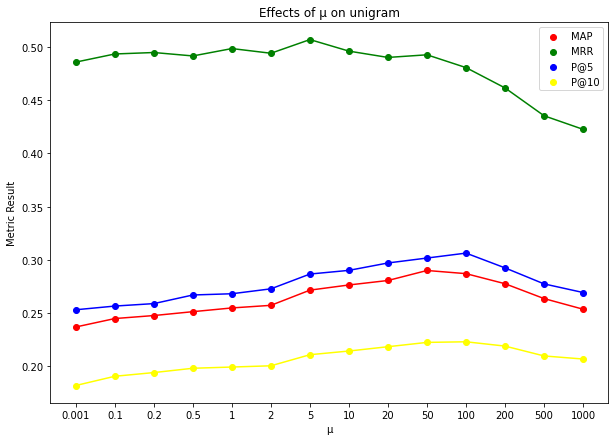

In [ ]:
metrics = ["MAP", "MRR", "P@5", "P@10"]
colors = ["red", "green", "blue", "yellow"]
mus = mu_unigram_results[metrics[0]].keys()

for metric, color in zip(metrics, colors):
  xs = range(1, 15)
  ys = [mu_unigram_results[metric][mu] for mu in mus]

  plt.plot(xs, ys, c=color)
  plt.scatter(xs, ys, c=color, label=metric)

plt.title("Effects of μ on unigram")
plt.xticks(xs, [str(mu) for mu in mus])
plt.xlabel("μ")
plt.ylabel("Metric Result")
plt.legend()
plt.gcf().set_size_inches(10, 7)
plt.show()

In [ ]:
mu_unigram_results

{'MAP': {0.001: 0.23701765446513343,
  0.1: 0.24493010959618042,
  0.2: 0.2477524223288559,
  0.5: 0.2513888729019365,
  1: 0.2548917614113548,
  2: 0.2573338635367293,
  5: 0.27160417898426303,
  10: 0.27645691036520703,
  20: 0.28065995383990633,
  50: 0.2900448365760364,
  100: 0.28707860173550986,
  200: 0.2776158414174927,
  500: 0.26367558483552817,
  1000: 0.2536954523230252},
 'MRR': {0.001: 0.4856569410037619,
  0.1: 0.4932929626571245,
  0.2: 0.49465547297917245,
  0.5: 0.49143958161299206,
  1: 0.4983668226442794,
  2: 0.49396733645288565,
  5: 0.5068056702449766,
  10: 0.4959560510138544,
  20: 0.49004037067620887,
  50: 0.4925107808055785,
  100: 0.48049362326818973,
  200: 0.4614047160289935,
  500: 0.4352899348564088,
  1000: 0.4225410588127351},
 'P@5': {0.001: 0.2531791907514451,
  0.1: 0.2566473988439307,
  0.2: 0.25895953757225443,
  0.5: 0.2670520231213873,
  1: 0.26820809248554917,
  2: 0.27283236994219656,
  5: 0.2867052023121387,
  10: 0.29017341040462424,
  20: 

### Bigram $\lambda$

In [ ]:
lambda_bigram_results = {"MAP": dict(), "MRR": dict(), "P@5": dict(), "P@10": dict()}
for lambda_ in [0.001, 0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99, 0.999]:
  print(f"lambda_ = {lambda_}")
  bigram_recommender = BigramRecommender(preprocess=preprocess, number_recommendation=10, mu=50, lambda_=lambda_)
  bigram_recommender.calculate_statistics(dataset=train_dataset_ngram)
  evaluator = Evaluator(bigram_recommender)

  lambda_bigram_results["MAP"][lambda_] = evaluator.evaluate_map(valid_dataset_evaluation)
  lambda_bigram_results["MRR"][lambda_] = evaluator.evaluate_mrr(valid_dataset_evaluation)
  lambda_bigram_results["P@5"][lambda_] = evaluator.evaluate_p_at_n(valid_dataset_evaluation, n=5)
  lambda_bigram_results["P@10"][lambda_] = evaluator.evaluate_p_at_n(valid_dataset_evaluation, n=10)

lambda_ = 0.001
lambda_ = 0.01
lambda_ = 0.1
lambda_ = 0.2
lambda_ = 0.5
lambda_ = 0.8
lambda_ = 0.9
lambda_ = 0.99
lambda_ = 0.999


In [ ]:
lambda_bigram_results

{'MAP': {0.001: 0.2934612529351104,
  0.01: 0.28990639324638967,
  0.1: 0.2736717030203322,
  0.2: 0.27269015840077165,
  0.5: 0.2635133816366689,
  0.8: 0.24816562713790277,
  0.9: 0.24523244519460527,
  0.99: 0.2407894097916194,
  0.999: 0.2389683711642224},
 'MRR': {0.001: 0.49071474447196967,
  0.01: 0.48838884301312036,
  0.1: 0.47505275713368195,
  0.2: 0.4835305991375356,
  0.5: 0.49009771538673275,
  0.8: 0.47265345444536194,
  0.9: 0.4706463895770254,
  0.99: 0.4669304523350766,
  0.999: 0.4669304523350766},
 'P@5': {0.001: 0.307514450867052,
  0.01: 0.3052023121387283,
  0.1: 0.28670520231213886,
  0.2: 0.27745664739884407,
  0.5: 0.2601156069364163,
  0.8: 0.2531791907514451,
  0.9: 0.2497109826589596,
  0.99: 0.2439306358381503,
  0.999: 0.24277456647398843},
 'P@10': {0.001: 0.23236994219653184,
  0.01: 0.23179190751445086,
  0.1: 0.21445086705202304,
  0.2: 0.21040462427745651,
  0.5: 0.20289017341040455,
  0.8: 0.1936416184971098,
  0.9: 0.19190751445086704,
  0.99: 0.18

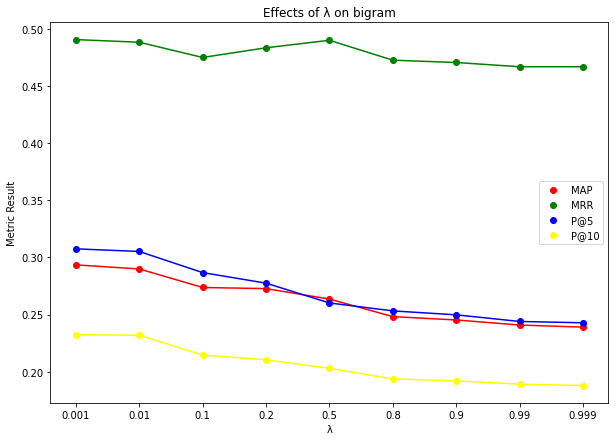

In [ ]:
metrics = ["MAP", "MRR", "P@5", "P@10"]
colors = ["red", "green", "blue", "yellow"]
lambdas = lambda_bigram_results[metrics[0]].keys()

for metric, color in zip(metrics, colors):
  xs = range(1, 10)
  ys = [lambda_bigram_results[metric][lambda_] for lambda_ in lambdas]

  plt.plot(xs, ys, c=color)
  plt.scatter(xs, ys, c=color, label=metric)

plt.title("Effects of λ on bigram")
plt.xticks(xs, [str(lambda_) for lambda_ in lambdas])
plt.xlabel("λ")
plt.ylabel("Metric Result")
plt.legend()
plt.gcf().set_size_inches(10, 7)
plt.show()

# BERT

In [ ]:
from numpy import dot
from numpy.linalg import norm

class BertRecommender():
  # Refrence: https://colab.research.google.com/drive/1yFphU6PW9Uo6lmDly_ud9a6c4RCYlwdX#scrollTo=pTJV8AFFcLbL

  def __init__(self, preprocess, number_recommendation):
    self.preprocess = preprocess
    self.number_recommendation = number_recommendation
    self.search_space = None
    self._load_model()

  def _load_model(self):
    # Load pre-trained model tokenizer (vocabulary)
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Load pre-trained model (weights)
    self.model = BertModel.from_pretrained('bert-base-uncased',
                                            output_hidden_states = True, # Whether the model returns all hidden-states.
                                            )

    # Put the model in "evaluation" mode, meaning feed-forward operation.
    self.model.eval()

  def calculate_train_embedding(self, dataset):

    self.search_space = list()
    
    for i, data in enumerate(dataset):
      if i%1000==0: print(f"{i*100//len(dataset)}%", end=" ")
      text = data["text"]
      qid = data["qid"]
      text = self.preprocess(text)
      vector = self._sentence_embedding(text)

      self.search_space.append({"vector": vector, "qid": qid, "text":text})

  @staticmethod
  def cosine_similarity(vector1, vector2):
    return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

  def _sentence_embedding(self, text):
    marked_text = "[CLS] " + text + " [SEP]"

    # Tokenize our sentence with the BERT tokenizer.
    tokenized_text = self.tokenizer.tokenize(marked_text)

    # Map the token strings to their vocabulary indeces.
    indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)

    segments_ids = [1] * len(tokenized_text)

    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    # Get hidden state of BERT model
    with torch.no_grad():
      outputs = self.model(tokens_tensor, segments_tensors)
      hidden_states = outputs[2]

    # Concatenate the tensors for all layers. We use `stack` here to
    # create a new dimension in the tensor.
    # Just keeping the 4 last layers
    token_embeddings = torch.stack(hidden_states[9:], dim=0)

    # Remove dimension 1, the "batches".
    token_embeddings = torch.squeeze(token_embeddings, dim=1)

    # Swap dimensions 0 and 1.
    token_embeddings = token_embeddings.permute(1,0,2)

    # Mean of all tokens in the 4 last layers
    return torch.mean(torch.mean(token_embeddings,dim=0),dim=0)

  def recommend(self, text):
    text_vector = self._sentence_embedding(text)

    similar_document_list = []

    for document in self.search_space:
      similarity = self.cosine_similarity(document["vector"], text_vector)

      similar_document_list.append({"similarity": similarity,
                                    "qid": document["qid"], "text":document["text"]})

    return nlargest(self.number_recommendation, similar_document_list, key=lambda x:x["similarity"])

In [ ]:
train_dataset_bert = list()

qid_set = set()

for i, data in train_dataset.iterrows():
  qid = data["qid2"]
  if qid not in qid_set:
    qid_set.add(qid)
    train_dataset_bert.append({"text": data["question2"], "qid": qid})

# Siamese

In [19]:
maximum_token_number = 0
for dataset_part in [train_dataset, test_dataset, valid_dataset]:
  for _, data in dataset_part.iterrows():
    maximum_token_number = max(maximum_token_number, 
                              len(data["question1"].split()),
                              len(data["question2"].split()))
  
print(f"maximum_token_number = {maximum_token_number}")

maximum_token_number = 60


In [7]:
def tokenize(text, embedding_model):
  text = preprocess(text)
  tokens = text.split()

  oov_vocab = embedding_model.vocab.get("<oov>")
  pad_vocab = embedding_model.vocab.get("<pad>")
  
  indexes = []
  for token in tokens:
    indexes.append(embedding_model.vocab.get(token, oov_vocab).index)

  for i in range(60-len(tokens)):
    indexes.append(pad_vocab.index)

  return indexes

In [8]:
def convert_dataset_to_tf_format(dataset, embedding_model):
  dataset_input1 = []
  dataset_input2 = []
  dataset_label = []

  for i, data in dataset.iterrows():
    question1 = data["question1"]
    question2 = data["question2"]

    question1_indexes = tokenize(question1, embedding_model)
    question2_indexes = tokenize(question2, embedding_model)
    
    dataset_input1.append(question1_indexes)
    dataset_input2.append(question2_indexes)
    dataset_label.append(data["is_duplicate"])

  dataset_input1 = tf.convert_to_tensor(dataset_input1)
  dataset_input2 = tf.convert_to_tensor(dataset_input2)
  dataset_label = tf.convert_to_tensor(dataset_label)

  return dataset_input1, dataset_input2, dataset_label

## Load Pretrained Word Embedding

### Word2Vec

In [9]:
api.load("word2vec-google-news-300", return_path=True)

[==================================================] 100.0% 1662.8/1662.8MB downloaded


'/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz'

In [10]:
!gunzip /root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz

In [9]:
word2vec_model = KeyedVectors.load_word2vec_format('/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300', limit=500000, binary=True)

In [10]:
word2vec_model.add(["<oov>", "<pad>"], [np.zeros(300), np.zeros(300)])

### FastText

In [13]:
fasttext_model = api.load("fasttext-wiki-news-subwords-300")

[==================================================] 100.0% 958.5/958.4MB downloaded


In [14]:
fasttext_model.add(["<oov>", "<pad>"], [np.zeros(300), np.zeros(300)])

### GloVe

In [76]:
!gdown https://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip /content/glove.twitter.27B.zip
glove_file = datapath('/content/glove.twitter.27B.100d.txt')
tmp_file = get_tmpfile("/content/temp_word2vec.txt")
glove2word2vec(glove_file, tmp_file)
glove_model = KeyedVectors.load_word2vec_format(tmp_file)

Downloading...
From: https://nlp.stanford.edu/data/glove.twitter.27B.zip
To: /content/glove.twitter.27B.zip
100% 1.52G/1.52G [04:45<00:00, 5.33MB/s]
Archive:  /content/glove.twitter.27B.zip
replace glove.twitter.27B.25d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


In [77]:
glove_model.add(["<oov>", "<pad>"], [np.zeros(100), np.zeros(100)])

## Siamese Network

In [40]:
import tensorflow.keras as keras
import keras.backend as K
from keras.layers import Bidirectional, LSTM, Lambda, Dense, Concatenate, Dot
from keras.models import Sequential

class Siamese(keras.Model):
  # Source: https://towardsdatascience.com/quora-question-pairs-detecting-text-similarity-using-siamese-networks-a370f039731b

  def __init__(self, embedding_model, lstm_units=64, bidirectional_enable=True, merging_type=0):
    super().__init__()
    self.embedding_model = embedding_model

    self.embedding_layer = self.embedding_model.get_keras_embedding()

    self.lstm_layer = LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2)

    self.merging_type = merging_type

    if bidirectional_enable:
      self.lstm_layer = Bidirectional(self.lstm_layer)
    
    if merging_type==0:   
      self.distance_layer = Lambda(function=lambda x: K.abs(x[0] - x[1]), output_shape=lambda x: x[0])
      self.output_layer = Dense(1, activation='sigmoid')

    elif merging_type==1:
      self.concatenate = Concatenate()
      self.output_layer = Dense(1, activation='sigmoid')

    elif merging_type==2:
      self.output_layer = Dot(axes=1, normalize=True)

  def text_embedding(self, texts):
    word_embedding = self.embedding_layer(texts)
    return self.lstm_layer(word_embedding)

  def merge(self, texts1_embedding, texts2_embedding):
    if self.merging_type==0:
      x = self.distance_layer([texts1_embedding, texts2_embedding])
      return self.output_layer(x)
    elif self.merging_type==1:
      x = self.concatenate([texts1_embedding, texts2_embedding])
      return self.output_layer(x)
    elif self.merging_type==2:
      return self.output_layer([texts1_embedding, texts2_embedding])

  def call(self, inputs):
    texts1, texts2 = inputs

    texts1_embedding = self.text_embedding(texts1)
    texts2_embedding = self.text_embedding(texts2)

    return self.merge(texts1_embedding, texts2_embedding)

## Siamese Recommender

In [ ]:
from keras.utils.data_utils import zipfile
from numpy import dot
from numpy.linalg import norm

class SiameseRecommender():

  def __init__(self, preprocess, number_recommendation,
               siamese_model, embedding_model):
    self.preprocess = preprocess
    self.number_recommendation = number_recommendation
    self.search_space = None
    self.siamese_model = siamese_model
    self.embedding_model = embedding_model

  def calculate_train_embedding(self, dataset):

    self.search_space = list()
    self.train_matrix = None

    indexes = []
    for i, data in enumerate(dataset):
      if i%1000==0: print(f"{i*100//len(dataset)}%", end=" ")
      text = data["text"]
      qid = data["qid"]
      index = tokenize(text, self.embedding_model)
      indexes.append(index)
      self.search_space.append({"qid": qid, "text":text})

    self.train_matrix = self.siamese_model.text_embedding(tf.constant(indexes))

  def recommend(self, text):
    test_indexes = tokenize(text, self.embedding_model)

    test_vector = self.siamese_model.text_embedding(tf.convert_to_tensor([test_indexes]))

    test_matrix = tf.tile(test_vector, (self.train_matrix.shape[0], 1))

    similarities = self.siamese_model.merge(self.train_matrix, test_matrix)  

    most_similar_index = np.argsort(-(similarities.numpy().squeeze()))[:self.number_recommendation]

    output = []

    for index in most_similar_index:
      output.append({"qid": self.search_space[index]["qid"],
                     "text": self.search_space[index]["text"],
                     "similarity": similarities[index][0]})

    return output

In [ ]:
train_dataset_siamese = list()

qid_set = set()

for i, data in train_dataset.iterrows():
  qid = data["qid2"]
  if qid not in qid_set:
    qid_set.add(qid)
    train_dataset_siamese.append({"text": data["question2"], "qid": qid})

## Select Model

### Word Embedding

#### Word2Vec

In [69]:
embedding_model = word2vec_model

dataset_train_input1, dataset_train_input2, dataset_train_label = convert_dataset_to_tf_format(train_dataset, embedding_model)
dataset_test_input1, dataset_test_input2, dataset_test_label = convert_dataset_to_tf_format(test_dataset, embedding_model)
dataset_valid_input1, dataset_valid_input2, dataset_valid_label = convert_dataset_to_tf_format(valid_dataset, embedding_model)

model = Siamese(embedding_model=embedding_model, bidirectional_enable=True, merging_type=2)

es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

history = model.fit([dataset_train_input1, dataset_train_input2],
                  dataset_train_label,
                  validation_data=([dataset_valid_input1, dataset_valid_input2], dataset_valid_label),
                  epochs=10, callbacks=[es_callback])

model.evaluate([dataset_test_input1, dataset_test_input2], dataset_test_label)

Epoch 1/10
1165/1165 [==============================] - 991s 843ms/step - loss: 0.4265 - accuracy: 0.8282 - val_loss: 0.3129 - val_accuracy: 0.9129
Epoch 2/10
1165/1165 [==============================] - 972s 834ms/step - loss: 0.3689 - accuracy: 0.8521 - val_loss: 0.2858 - val_accuracy: 0.9158
Epoch 3/10
1165/1165 [==============================] - 969s 832ms/step - loss: 0.3460 - accuracy: 0.8597 - val_loss: 0.2482 - val_accuracy: 0.9218
Epoch 4/10
1165/1165 [==============================] - 958s 822ms/step - loss: 0.3075 - accuracy: 0.8828 - val_loss: 0.2571 - val_accuracy: 0.9218
Epoch 5/10
31/31 [==============================] - 3s 100ms/step - loss: 0.1172 - accuracy: 0.9918


[0.11721412092447281, 0.9918367266654968]

In [ ]:
siamese_recommender = SiameseRecommender(preprocess=preprocess,
                                         number_recommendation=10,
                                         siamese_model=model,
                                         embedding_model=embedding_model)

In [ ]:
siamese_recommender.calculate_train_embedding(train_dataset_siamese)

0% 6% 12% 18% 24% 30% 36% 42% 48% 54% 60% 66% 72% 78% 84% 90% 96% 

In [75]:
evaluator = Evaluator(siamese_recommender)
evaluator.evaluation_report(dataset=test_dataset_evaluation)

Evaluation Summary:
P@5  = 23.97%
P@10 = 16.71%
MAP  = 17.35%
MRR  = 47.63%


#### FastText

In [ ]:
embedding_model = fasttext_model

dataset_train_input1, dataset_train_input2, dataset_train_label = convert_dataset_to_tf_format(train_dataset, embedding_model)
dataset_test_input1, dataset_test_input2, dataset_test_label = convert_dataset_to_tf_format(test_dataset, embedding_model)
dataset_valid_input1, dataset_valid_input2, dataset_valid_label = convert_dataset_to_tf_format(valid_dataset, embedding_model)

model = Siamese(embedding_model=embedding_model, bidirectional_enable=True, merging_type=2)

es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

history = model.fit([dataset_train_input1, dataset_train_input2],
                  dataset_train_label,
                  validation_data=([dataset_valid_input1, dataset_valid_input2], dataset_valid_label),
                  epochs=10, callbacks=[es_callback])

model.evaluate([dataset_test_input1, dataset_test_input2], dataset_test_label)

Epoch 1/10
1165/1165 [==============================] - 966s 818ms/step - loss: 0.4278 - accuracy: 0.8255 - val_loss: 0.3907 - val_accuracy: 0.8980
Epoch 2/10
1165/1165 [==============================] - 937s 804ms/step - loss: 0.4150 - accuracy: 0.8371 - val_loss: 0.3448 - val_accuracy: 0.8990
Epoch 3/10
1165/1165 [==============================] - 925s 794ms/step - loss: 0.4427 - accuracy: 0.8243 - val_loss: 0.3337 - val_accuracy: 0.8941
Epoch 4/10
1165/1165 [==============================] - 925s 794ms/step - loss: 0.3738 - accuracy: 0.8481 - val_loss: 0.2773 - val_accuracy: 0.9129
Epoch 5/10
1165/1165 [==============================] - 923s 793ms/step - loss: 0.3384 - accuracy: 0.8686 - val_loss: 0.3226 - val_accuracy: 0.8990
Epoch 6/10
1165/1165 [==============================] - 922s 791ms/step - loss: 0.3272 - accuracy: 0.8730 - val_loss: 0.2675 - val_accuracy: 0.9099
Epoch 7/10
1165/1165 [==============================] - 916s 786ms/step - loss: 0.3582 - accuracy: 0.8555 - val_

[0.18534262478351593, 0.968367338180542]

In [ ]:
siamese_recommender = SiameseRecommender(preprocess=preprocess,
                                         number_recommendation=10,
                                         siamese_model=model,
                                         embedding_model=embedding_model)

In [ ]:
siamese_recommender.calculate_train_embedding(train_dataset_siamese)

0% 6% 12% 18% 24% 30% 36% 42% 48% 54% 60% 66% 72% 78% 84% 90% 96% 

In [ ]:
evaluator = Evaluator(siamese_recommender)
evaluator.evaluation_report(dataset=test_dataset_evaluation)

Evaluation Summary:
P@5  = 16.16%
P@10 = 12.4%
MAP  = 11.35%
MRR  = 37.85%


#### GloVe

In [78]:
embedding_model = glove_model

dataset_train_input1, dataset_train_input2, dataset_train_label = convert_dataset_to_tf_format(train_dataset, embedding_model)
dataset_test_input1, dataset_test_input2, dataset_test_label = convert_dataset_to_tf_format(test_dataset, embedding_model)
dataset_valid_input1, dataset_valid_input2, dataset_valid_label = convert_dataset_to_tf_format(valid_dataset, embedding_model)

model = Siamese(embedding_model=embedding_model, bidirectional_enable=True, merging_type=2)

es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

history = model.fit([dataset_train_input1, dataset_train_input2],
                  dataset_train_label,
                  validation_data=([dataset_valid_input1, dataset_valid_input2], dataset_valid_label),
                  epochs=10, callbacks=[es_callback])

model.evaluate([dataset_test_input1, dataset_test_input2], dataset_test_label)

Epoch 1/10
1165/1165 [==============================] - 993s 845ms/step - loss: 0.4083 - accuracy: 0.8331 - val_loss: 0.2891 - val_accuracy: 0.9099
Epoch 2/10
1165/1165 [==============================] - 1004s 862ms/step - loss: 0.3359 - accuracy: 0.8656 - val_loss: 0.2430 - val_accuracy: 0.9238
Epoch 3/10
1165/1165 [==============================] - 972s 834ms/step - loss: 0.3095 - accuracy: 0.8813 - val_loss: 0.2415 - val_accuracy: 0.9297
Epoch 4/10
1165/1165 [==============================] - 970s 833ms/step - loss: 0.2836 - accuracy: 0.8921 - val_loss: 0.2421 - val_accuracy: 0.9297
Epoch 5/10
1165/1165 [==============================] - 970s 833ms/step - loss: 0.2651 - accuracy: 0.9057 - val_loss: 0.2229 - val_accuracy: 0.9287
Epoch 6/10
1165/1165 [==============================] - 965s 828ms/step - loss: 0.2464 - accuracy: 0.9122 - val_loss: 0.2329 - val_accuracy: 0.9238
Epoch 7/10
31/31 [==============================] - 3s 99ms/step - loss: 0.1131 - accuracy: 0.9735


[0.11309739947319031, 0.9734693765640259]

In [79]:
siamese_recommender = SiameseRecommender(preprocess=preprocess,
                                         number_recommendation=10,
                                         siamese_model=model,
                                         embedding_model=embedding_model)

In [80]:
siamese_recommender.calculate_train_embedding(train_dataset_siamese)

0% 6% 12% 18% 24% 30% 36% 42% 48% 54% 60% 66% 72% 78% 84% 90% 96% 

In [81]:
evaluator = Evaluator(siamese_recommender)
evaluator.evaluation_report(dataset=test_dataset_evaluation)

Evaluation Summary:
P@5  = 30.27%
P@10 = 21.99%
MAP  = 22.22%
MRR  = 54.33%


### Merging Strategy

#### Distance

In [ ]:
embedding_model = glove_model

dataset_train_input1, dataset_train_input2, dataset_train_label = convert_dataset_to_tf_format(train_dataset, embedding_model)
dataset_test_input1, dataset_test_input2, dataset_test_label = convert_dataset_to_tf_format(test_dataset, embedding_model)
dataset_valid_input1, dataset_valid_input2, dataset_valid_label = convert_dataset_to_tf_format(valid_dataset, embedding_model)

model = Siamese(embedding_model=embedding_model, bidirectional_enable=True, merging_type=0)

es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

history = model.fit([dataset_train_input1, dataset_train_input2],
                  dataset_train_label,
                  validation_data=([dataset_valid_input1, dataset_valid_input2], dataset_valid_label),
                  epochs=10, callbacks=[es_callback])

model.evaluate([dataset_test_input1, dataset_test_input2], dataset_test_label)

Epoch 1/10
  96/1165 [=>............................] - ETA: 18:53 - loss: 0.5407 - accuracy: 0.7933

In [ ]:
siamese_recommender = SiameseRecommender(preprocess=preprocess,
                                         number_recommendation=10,
                                         siamese_model=model,
                                         embedding_model=embedding_model)

In [ ]:
siamese_recommender.calculate_train_embedding(train_dataset_siamese)

In [ ]:
evaluator = Evaluator(siamese_recommender)
evaluator.evaluation_report(dataset=test_dataset_evaluation)

#### Concatenate

In [ ]:
embedding_model = glove_model

dataset_train_input1, dataset_train_input2, dataset_train_label = convert_dataset_to_tf_format(train_dataset, embedding_model)
dataset_test_input1, dataset_test_input2, dataset_test_label = convert_dataset_to_tf_format(test_dataset, embedding_model)
dataset_valid_input1, dataset_valid_input2, dataset_valid_label = convert_dataset_to_tf_format(valid_dataset, embedding_model)

model = Siamese(embedding_model=embedding_model, bidirectional_enable=True, merging_type=1)

es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

history = model.fit([dataset_train_input1, dataset_train_input2],
                  dataset_train_label,
                  validation_data=([dataset_valid_input1, dataset_valid_input2], dataset_valid_label),
                  epochs=10, callbacks=[es_callback])

model.evaluate([dataset_test_input1, dataset_test_input2], dataset_test_label)

In [ ]:
siamese_recommender = SiameseRecommender(preprocess=preprocess,
                                         number_recommendation=10,
                                         siamese_model=model,
                                         embedding_model=embedding_model)

In [ ]:
siamese_recommender.calculate_train_embedding(train_dataset_siamese)

In [ ]:
evaluator = Evaluator(siamese_recommender)
evaluator.evaluation_report(dataset=test_dataset_evaluation)

#### Cosine

In [ ]:
embedding_model = glove_model

dataset_train_input1, dataset_train_input2, dataset_train_label = convert_dataset_to_tf_format(train_dataset, embedding_model)
dataset_test_input1, dataset_test_input2, dataset_test_label = convert_dataset_to_tf_format(test_dataset, embedding_model)
dataset_valid_input1, dataset_valid_input2, dataset_valid_label = convert_dataset_to_tf_format(valid_dataset, embedding_model)

model = Siamese(embedding_model=embedding_model, bidirectional_enable=True, merging_type=2)

es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

history = model.fit([dataset_train_input1, dataset_train_input2],
                  dataset_train_label,
                  validation_data=([dataset_valid_input1, dataset_valid_input2], dataset_valid_label),
                  epochs=10, callbacks=[es_callback])

model.evaluate([dataset_test_input1, dataset_test_input2], dataset_test_label)

Epoch 1/10
1165/1165 [==============================] - 993s 845ms/step - loss: 0.4083 - accuracy: 0.8331 - val_loss: 0.2891 - val_accuracy: 0.9099
Epoch 2/10
1165/1165 [==============================] - 1004s 862ms/step - loss: 0.3359 - accuracy: 0.8656 - val_loss: 0.2430 - val_accuracy: 0.9238
Epoch 3/10
1165/1165 [==============================] - 972s 834ms/step - loss: 0.3095 - accuracy: 0.8813 - val_loss: 0.2415 - val_accuracy: 0.9297
Epoch 4/10
1165/1165 [==============================] - 970s 833ms/step - loss: 0.2836 - accuracy: 0.8921 - val_loss: 0.2421 - val_accuracy: 0.9297
Epoch 5/10
1165/1165 [==============================] - 970s 833ms/step - loss: 0.2651 - accuracy: 0.9057 - val_loss: 0.2229 - val_accuracy: 0.9287
Epoch 6/10
1165/1165 [==============================] - 965s 828ms/step - loss: 0.2464 - accuracy: 0.9122 - val_loss: 0.2329 - val_accuracy: 0.9238
Epoch 7/10
31/31 [==============================] - 3s 99ms/step - loss: 0.1131 - accuracy: 0.9735


[0.11309739947319031, 0.9734693765640259]

In [ ]:
siamese_recommender = SiameseRecommender(preprocess=preprocess,
                                         number_recommendation=10,
                                         siamese_model=model,
                                         embedding_model=embedding_model)

In [ ]:
siamese_recommender.calculate_train_embedding(train_dataset_siamese)

0% 6% 12% 18% 24% 30% 36% 42% 48% 54% 60% 66% 72% 78% 84% 90% 96% 

In [ ]:
evaluator = Evaluator(siamese_recommender)
evaluator.evaluation_report(dataset=test_dataset_evaluation)

Evaluation Summary:
P@5  = 30.27%
P@10 = 21.99%
MAP  = 22.22%
MRR  = 54.33%


# Evaluation

In [70]:
class Evaluator():
  def __init__(self, recommender):
    self.recommender = recommender

  def evaluate_p_at_n(self, dataset, n):
    precision = 0
    
    for data in dataset:
      text = data["text"]
      positive_qids = data["positive_qids"]
    
      outputs = self.recommender.recommend(text)

      matched_number = 0

      for i in range(n):
        qid = outputs[i]["qid"]

        if qid in positive_qids:
          matched_number += 1

      precision += matched_number/n

    return precision / len(dataset)

  def evaluate_map(self, dataset):
    sum_ap = 0
    for data in dataset:    
      ap = self._evaluate_ap(data)
      sum_ap += ap

    map = sum_ap / len(dataset)
    return map

  def _evaluate_ap(self, data):
    text = data["text"]
    positive_qids = data["positive_qids"]

    outputs = self.recommender.recommend(text)

    matched_number = 0
    sum_precision = 0
    for i, output in enumerate(outputs):
      if output["qid"] in positive_qids:
        matched_number += 1

        precision = matched_number / (i+1)
        sum_precision += precision
    
    return sum_precision / len(positive_qids)

  def evaluate_mrr(self, dataset):
    sum_rr = 0
    for data in dataset:    
      rr = self._evaluate_rr(data)
      sum_rr += rr

    mrr = sum_rr / len(dataset)
    return mrr

  def _evaluate_rr(self, data):
    text = data["text"]
    positive_qids = data["positive_qids"]

    outputs = self.recommender.recommend(text)

    for i, output in enumerate(outputs):
      if output["qid"] in positive_qids:
        return 1 / (i+1)
    
    return 0
  
  def evaluation_report(self, dataset):
    print("Evaluation Summary:")
    print(f"P@5  = {round(self.evaluate_p_at_n(dataset=dataset, n=5)*100, 2)}%")
    print(f"P@10 = {round(self.evaluate_p_at_n(dataset=dataset, n=10)*100, 2)}%")
    print(f"MAP  = {round(self.evaluate_map(dataset=dataset)*100, 2)}%")
    print(f"MRR  = {round(self.evaluate_mrr(dataset=dataset)*100, 2)}%")

# Test

In [19]:
qid_set = set(test_dataset["qid1"].values)

test_dataset_evaluation = []

for qid in qid_set:

  qid_test_dataset = test_dataset[test_dataset["qid1"]==qid]

  text = qid_test_dataset.iloc[0]["question1"]
  positive_qids = set(qid_test_dataset["qid2"].values)

  test_dataset_evaluation.append({"text": text, "positive_qids": positive_qids})

In [20]:
np.average([len(data["positive_qids"]) for data  in  test_dataset_evaluation])

6.712328767123288

## TF-IDF

In [ ]:
start_time = time.time()
tfidf = TFIDF(top_word_number=2000, stop_word_number=100, preprocess=preprocess)
tfidf.process_corpus(train_dataset_text)
tfidf_recommender = TFIDFRecommender(tfidf=tfidf, number_recommendation=10)
tfidf_recommender.create_search_space(train_dataset_tfidf)
end_time = time.time()
print(f"Training Time = {round(end_time - start_time, 2)}s")

Training Time = 3.54s


In [ ]:
start_time = time.time()
evaluator = Evaluator(tfidf_recommender)
evaluator.evaluation_report(dataset=test_dataset_evaluation)
end_time = time.time()
print(f"Testing Time = {round(end_time - start_time, 2)}s")

Evaluation Summary:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


P@5  = 44.52%
P@10 = 31.71%
MAP  = 39.48%
MRR  = 62.77%
Testing Time = 200.69s


## Unigram

In [ ]:
start_time = time.time()
unigram_recommender = UnigramRecommender(preprocess=preprocess, number_recommendation=10, mu=50)
unigram_recommender.calculate_statistics(dataset=train_dataset_ngram)
end_time = time.time()
print(f"Training Time = {round(end_time - start_time, 2)}s")

Training Time = 0.57s


In [ ]:
start_time = time.time()
evaluator = Evaluator(unigram_recommender)
evaluator.evaluation_report(dataset=test_dataset_evaluation)
end_time = time.time()
print(f"Testing Time = {round(end_time - start_time, 2)}s")

Evaluation Summary:
P@5  = 39.86%
P@10 = 28.42%
MAP  = 37.55%
MRR  = 61.05%
Testing Time = 91.1s


## Bigram

In [ ]:
start_time = time.time()
bigram_recommender = BigramRecommender(preprocess=preprocess, number_recommendation=10, mu=50, lambda_=0.001)
bigram_recommender.calculate_statistics(dataset=train_dataset_ngram)
end_time = time.time()
print(f"Training Time = {round(end_time - start_time, 2)}s")

Training Time = 0.91s


In [ ]:
start_time = time.time()
evaluator = Evaluator(bigram_recommender)
evaluator.evaluation_report(dataset=test_dataset_evaluation)
end_time = time.time()
print(f"Testing Time = {round(end_time - start_time, 2)}s")

Evaluation Summary:
P@5  = 40.27%
P@10 = 28.15%
MAP  = 36.72%
MRR  = 60.75%
Testing Time = 165.45s


## BERT

In [ ]:
# Call the first time for loading model and ignore this time for training time
bert_recommender = BertRecommender(preprocess=preprocess, number_recommendation=10)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
start_time = time.time()
bert_recommender = BertRecommender(preprocess=preprocess, number_recommendation=10)
bert_recommender.calculate_train_embedding(train_dataset_bert)
end_time = time.time()
print(f"Training Time = {round(end_time - start_time, 2)}s")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0% 6% 12% 18% 24% 30% 36% 42% 48% 54% 60% 66% 72% 78% 84% 90% 96% Training Time = 2405.22s


In [ ]:
start_time = time.time()
evaluator = Evaluator(bert_recommender)
evaluator.evaluation_report(dataset=test_dataset_evaluation)
end_time = time.time()
print(f"Testing Time = {round(end_time - start_time, 2)}s")

Evaluation Summary:
P@5  = 45.75%
P@10 = 31.78%
MAP  = 41.4%
MRR  = 76.6%
Testing Time = 385.17s


## Siamese

In [ ]:
start_time = time.time()
bert_recommender = BertRecommender(preprocess=preprocess, number_recommendation=10)
bert_recommender.calculate_train_embedding(train_dataset_bert)
end_time = time.time()
print(f"Training Time = {round(end_time - start_time, 2)}s")

In [66]:
start_time = time.time()
evaluator = Evaluator(siamese_recommender)
evaluator.evaluation_report(dataset=test_dataset_evaluation)
end_time = time.time()
print(f"Testing Time = {round(end_time - start_time, 2)}s")

Evaluation Summary:
P@5  = 20.96%
P@10 = 14.32%
MAP  = 16.77%
MRR  = 46.53%
Testing Time = 283.22s


In [ ]:
start_time = time.time()
evaluator = Evaluator(siamese_recommender)
evaluator.evaluation_report(dataset=test_dataset_evaluation)
end_time = time.time()
print(f"Testing Time = {round(end_time - start_time, 2)}s")

Evaluation Summary:
P@5  = 22.47%
P@10 = 15.75%
MAP  = 16.18%
MRR  = 46.18%
Testing Time = 304.87s
